Bu kodun hazırlanmasında unsloth dökümantasyonundan yararlanılmıştır.

In [1]:
!pip install unsloth

Büyük Dil Modellerini olduğu gibi eğitmek için uzun zaman, fazla kaynak ve büyük veriye ihtiyaç vardır. Bu sorunun önüne geçmek için bir takım kütüphaneler ve yöntemler kullanılır. Kullanılan kütüphanelerden birisi de unsloth kütüphanesidir. Bu kütüphane istenilen açık kaynaklı büyük dil modellerini sisteme çeker ve çeşitli yöntemler sayesinde yüksek GB gereken veriyi küçülterek eğitimin kolay gerçekleştirilmesini ve çıktıların istenilen yerlerde saklanmasını sağlar. Unsloth kütüphanesinden kısaca bahsettiğimize göre yöntemlere değinelim.

Bahsedilen ve kodta geçen yöntemlerden birisi de 4bit kuantizasyon tekniğidir. Model ağırlıkları genellikle 32 bit float ya da 16 bit float olarak saklanır. Büyük modellerde bu ağırlıklar sistemde çok fazla yer kaplar. 4 bit kuantizasyon yöntemi ile ağırlıklar normalden 4 ile 8 kat daha az yer kaplar. Ancak saklanan verinin kesinliğinin (precision) düşük 16 ve 32 bitliğe göre daha düşük olmasından dolayı sonuçlar teorik olarak biraz düşük çıkabilir. Ancak modern tekniklerle (örn. Quantization-Aware Training, GPTQ) kayıp minimuma indirilebilir.

## Quantization-Aware Training (QAT)

Modeli FP32 veya FP16 olarak eğitirken aynı zamanda ağırlıkların kuantize edilmiş hallerini de simüle eder. Eğitim sırasında ağırlıklar hem float hem de kuantize edilmiş halde bulunur. Bu yöntemin amacı kuantizasyon sonrası performans kaybını önceden tahmin etmek ve minimize etmektir. Forward pass sırasında model, kuantize edilmiş ağırlıkları kullanır. Backpropagation sırasında gradient’ler float ağırlıklar üzerinden hesaplanır. Böylece model, kuantize edilmiş ağırlıkların getirdiği hataya "alışır" ve performans kaybı minimize edilir. Eğitim süresi artar, çünkü kuantizasyon simülasyonu ek hesaplama gerektirir.


## GPTQ (Gradient-based Post-Training Quantization)

Büyük modelleri eğittikten sonra kuantize eder. Gradient kullanarak 4-bit veya 3-bit kuantizasyon sırasında hatayı minimize eder. Model eğitildikten sonra ağırlıklar alınır. GPTQ, ağırlıkları grup veya blok bazlı olarak kuantize eder.
Kuantizasyon hatasını minimize etmek için local gradient’ler kullanılır (gradient descent ile optimize edilir, ama model yeniden eğitilmez). Sonuç olarak 4-bit veya 3-bit ağırlıklar, orijinal model performansına çok yakın bir doğrulukla elde edilir. Modeli yeniden eğitmek gerekmez. Post-training adımı, özellikle büyük modellerde zaman alabilir.

In [2]:
import torch
from unsloth import FastVisionModel

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True,
    # True or unsloth for long context
    use_gradient_checkpointing = 'unsloth'
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.2: Fast Mllama patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Vision modellerde vision_layerları, language layerları, attention ve mlp modülleri finetune edeceğimiz için True verdik
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers = True,
    finetune_language_layers = True,
    finetune_attention_modules = True,
    finetune_mlp_modules = True,

    r = 16,
    lora_alpha = 16,
    lora_dropout = 0,
    bias = 'none',
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth: Making `model.base_model.model.model.vision_model.transformer` require gradients


In [4]:
from datasets import load_dataset

dataset = load_dataset("unsloth/Radiology_mini", split="train")

In [5]:
dataset

Dataset({
    features: ['image', 'image_id', 'caption', 'cui'],
    num_rows: 1978
})

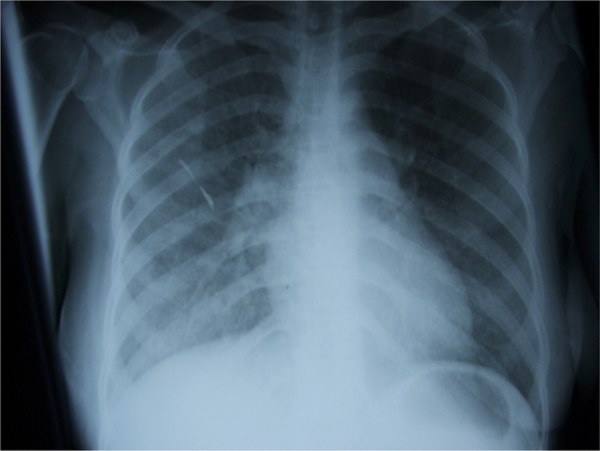

In [6]:
import random
rand_int = random.randint(0, len(dataset) - 1)
dataset[rand_int]['image']

In [7]:
dataset[rand_int]['caption']

'Chest X-ray on Day+1, diffuse interstitial shadowing noted throughout both lung fields, greater on the right.'

To format the dataset, all vision finetuning tasks should be formatted as follows:

[

{ "role": "user",
  "content": [{"type": "text",  "text": instruction}, {"type": "image", "image": image} ]
},

{ "role": "assistant",
  "content": [{"type": "text",  "text": answer} ]
},

]

We will craft an custom instruction asking the VLM to be an expert radiographer. Notice also instead of just 1 instruction, you can add multiple turns to make it a dynamic conversation.

In [8]:
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["caption"]} ]
        },
    ]
    return { "messages" : conversation }
pass

In [9]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [10]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an expert radiographer. Describe accurately what you see in this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=657x442>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Panoramic radiography shows an osteolytic lesion in the right posterior maxilla with resorption of the floor of the maxillary sinus (arrows).'}]}]}

In [ ]:
# Inference modta modeli deniyoruz. Çoklu modeller için her modelin bir şablonu vardır. Görsel model için de oluşturuyoruz.
FastVisionModel.for_inference(model)
image = dataset[rand_int]['image']
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

This radiograph appears to be a frontal view of the thoracic region, specifically showcasing a human ribcage, which is the main area of focus within the image. The central part of the image seems to have some internal structures such as lungs, with the most prominent feature being the diaphragm. There appears to be some foreign objects present inside the thoracic cavity; one appears to be in the central chest region, and two others appear in the upper region of the left lung. Other organs visible include the lower part of the trachea and parts of the shoulder regions. The lower part of the image seems to display parts of


In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Mutlaka kullanılmalı
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Full eğitim için 1 atanır
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # Wandb, tensorboard vs kullanmak istemiyorsak none

        # Vision model finetune'u için bunlar belirtilmelidir.
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    ),
)

In [13]:
trainer_stats = trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,978 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 67,174,400 of 10,737,395,235 (0.63% trained)


Step,Training Loss
1,3.545600
2,3.555200
3,3.198900
4,2.859300
5,2.591200
6,2.508000
7,2.125600
8,1.880200
9,1.630700
10,1.341800


Unsloth: Will smartly offload gradients to save VRAM!


In [ ]:
FastVisionModel.for_inference(model) 

image = dataset[rand_int]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

This radiograph demonstrates diffuse interstitial disease (groundglass opacification) without any evidence of consolidative lung changes.<|eot_id|>


In [15]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")

[]